<a href="https://colab.research.google.com/github/Mahdi-Miri/Signal_Proccesing/blob/main/Signal_Proccesing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Readig

In [1]:
!pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.43
    Uninstalling SQLAlchemy-2.0.43:
      Successfully uninstalled SQLAlchemy-2.0.43
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.14.1 requires sqlalchemy<3.0.0,>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


##Modelling

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Flatten, Dense
from tensorflow.keras.models import Model
import numpy as np

# ---------------------------------------------------------------------------
# 1. Corrected Custom Layer for Autocorrelation
# ---------------------------------------------------------------------------

class AutocorrelationLayer(Layer):
    """
    A custom Keras layer to compute the autocorrelation of the input signal
    along the last axis and return the first 'lags' components.

    This version uses the full complex FFT/IFFT pair for a robust implementation
    of the Wiener-Khinchin theorem.
    """
    def __init__(self, lags, **kwargs):
        super(AutocorrelationLayer, self).__init__(**kwargs)
        # Number of autocorrelation lags to keep. Corresponds to the "first 10 seconds".
        self.lags = lags

    def call(self, inputs):
        # The input tensor is expected to have a shape like (batch, dim1, dim2, timesteps)

        # 1. Cast the real-valued input to complex numbers for the FFT
        inputs_complex = tf.cast(inputs, tf.complex64)

        # 2. Compute the full complex FFT along the last axis (time dimension)
        fft_values = tf.signal.fft(inputs_complex)

        # 3. Compute the power spectral density by multiplying the FFT by its complex conjugate.
        # The result is a complex tensor with zero imaginary parts. We DO NOT cast to real here.
        power_spectral_density = fft_values * tf.math.conj(fft_values)

        # 4. Compute the inverse FFT of the power spectrum to get the autocorrelation.
        autocorr_complex = tf.signal.ifft(power_spectral_density)

        # 5. The result should be real-valued, so we take the real part at the end.
        autocorr_real = tf.math.real(autocorr_complex)

        # 6. Slice the result to keep only the first 'lags' values.
        return autocorr_real[..., :self.lags]

    def compute_output_shape(self, input_shape):
        # This method helps Keras infer the output shape of the layer
        shape = list(input_shape)
        shape[-1] = self.lags
        return tuple(shape)


# ---------------------------------------------------------------------------
# 2. Build the Deep Learning Model (Corrected)
# ---------------------------------------------------------------------------

# Define the input shape as requested
INPUT_SHAPE = (60, 60, 100)
OUTPUT_UNITS = 1000
LAGS_TO_KEEP = 10

# Use the Keras Functional API, which is often more flexible
# Input Layer: Defines the shape of the input data
# Note: Using 'shape' instead of the deprecated 'input_shape'
inputs = Input(shape=INPUT_SHAPE)

# Custom Autocorrelation Layer
# Output shape will be (None, 60, 60, 10)
autocorr_output = AutocorrelationLayer(lags=LAGS_TO_KEEP)(inputs)

# Flatten Layer
# Output shape will be (None, 60 * 60 * 10) = (None, 36000)
flattened_output = Flatten()(autocorr_output)

# Feed-Forward (Dense) Layer
# Final output shape will be (None, 1000)
outputs = Dense(OUTPUT_UNITS, activation='relu')(flattened_output)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)


# ---------------------------------------------------------------------------
# 3. Model Summary and Testing
# ---------------------------------------------------------------------------

# Print the model summary to see the architecture
print("Model Summary:")
model.summary()

# Create a dummy input tensor to test the model
# The shape is (batch_size, 60, 60, 100). We use a batch size of 1.
dummy_input = tf.random.normal([1, 60, 60, 100])

# Pass the dummy input through the model to get the output
output = model(dummy_input)

# Print the shape of the final output
# It should be (1, 1000) as requested.
print(f"\nShape of a sample input: {dummy_input.shape}")
print(f"Shape of the final output: {output.shape}")

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 60, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ autocorrelation_layer           │ (None, 60, 60, 10)     │             0 │
│ (AutocorrelationLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │    36,001,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,001,000 (137.33 MB)

 Trainable params: 36,001,000 (137.33 MB)

 Non-trainable params: 0 (0.00 B)


Shape of a sample input: (1, 60, 60, 100)
Shape of the final output: (1, 1000)


##Task 1

In [3]:
from obspy.clients.fdsn import Client
client = Client("IRIS")  # Initialize Client to download data from IRIS
import glob
from scipy.signal import iirnotch, filtfilt
import os
import numpy as np
import matplotlib.pyplot as plt
from obspy.core import UTCDateTime, read, Stream
from obspy.core.inventory.inventory import read_inventory

In [4]:
def date_maker(year, month, day,hour, minute, second):
    year = str(int(year))
    month = str(int(month))
    day = str(int(day))
    hour = str(int(hour))
    minute = str(int(minute))
    second = str(int(second))

    if len(month) == 1:
        month = '0' + month
    if len(day) == 1:
        day = '0' + day
    if len(hour) == 1:
        hour = '0' + hour
    if len(minute) == 1:
        minute = '0' + minute
    if len(second) == 1:
        second = '0' + second

    YMDHMS = year + "-" + month + "-" + day + "-" + hour + "-" + minute + "-" + second
    return YMDHMS

In [5]:
def plot_spectrum(data, sampling_rate, title):
    n = len(data)
    fft_data = np.fft.rfft(data)
    freqs = np.fft.rfftfreq(n, 1 / sampling_rate)
    plt.figure(figsize=(8, 4))
    plt.plot(freqs, np.abs(fft_data))
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

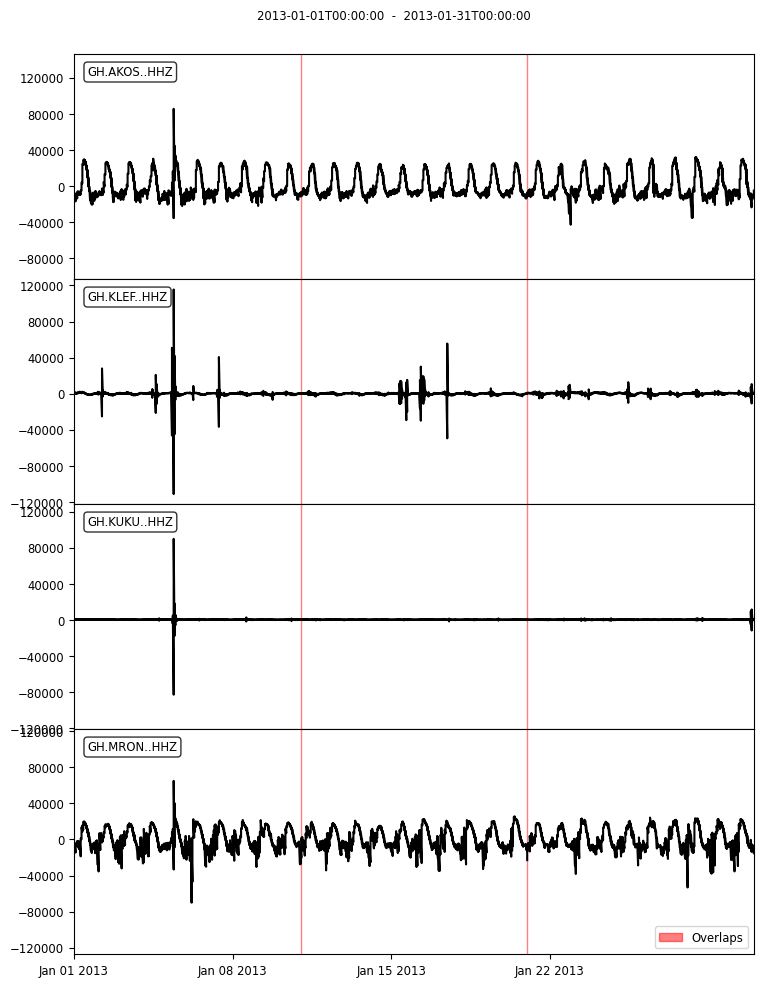

In [6]:
network = "GH"
# station_list = ['AKOS', 'KLEF', 'KUKU', 'MRON']
station_list = ['AKOS']
YMDHMS = date_maker(2013, 1, 1, 0, 0, 0.0)
Main_direc = "/content/wave"
st = read("/content/drive/MyDrive/Signal/2013-01-01-00-00-00.mseed")
st.plot()
start_time = UTCDateTime(2013, 1, 1, 0, 0, 0.0)
xml_dir = "/content/drive/MyDrive/Signal/"
xml_files = glob.glob(os.path.join(xml_dir, "*.xml"))
inventory = None

In [7]:
for xml_file in xml_files:
    inv = read_inventory(xml_file)
    if inventory is None:
        inventory = inv
    else:
        inventory += inv

In [8]:
pre_filt = (2, 4, 40.0, 50.0)

In [9]:
for station in station_list:
    print(station)
    for day in range(2):  # Adjust the range as per the actual number of days
        print(day)
        day_start = start_time + day * 86400  # 86400 seconds in a day
        day_end = day_start + 86400
        st_day = st.select(station=station).slice(starttime=day_start, endtime=day_end)
        # st_day.remove_response(inventory=inventory, pre_filt=pre_filt)
        # savemat('/home/shazam/Tokyo/Ghana_Collaboration/Matlab_codes/day_data_remove_response.mat', {'day_data_remove_response': st_day.traces[0].data})
        # st_day.detrend("spline", order=3, dspline=500)
        sampling_rate = st.traces[0].stats.sampling_rate
        # freq = 6.05  # Frequency to remove
        # df = 0.5  # Width of the notch (0.5 Hz range for fine removal)
        # freqmin = freq - df / 2.0
        # freqmax = freq + df / 2.0
        # Initialize a stream for stacking the daily PACs
        daily_pac_stack = Stream()
        for hour in range(24):
            print(hour)
            hour_start = day_start + hour * 3600  # 3600 seconds in an hour
            hour_end = hour_start + 3600
            st_hour = st_day.slice(starttime=hour_start, endtime=hour_end)
            # st_hour.detrend("spline", order=5, dspline=1000)
            try:
                st_hour.detrend("spline", order=5, dspline=1000)
            except ValueError as e:
                if "Interior knots t must satisfy Schoenberg-Whitney conditions" in str(e):
                    print(f"Skipping iteration due to spline error: {e}")
                    continue  # Skip this iteration and proceed with the next one
                else:
                    raise  # If it's a different ValueError, re-raise it
            st_hour.filter("highpass", freq=1.3, corners=3, zerophase=True)
            # st_hour.filter("lowpass", freq=13, corners=3, zerophase=True)
            while True:
                n = len(st_hour.traces[0].data)
                dt = st_hour.traces[0].stats.delta  # Sampling interval
                freqs = np.fft.rfftfreq(n, dt)  # Frequency array
                fft_vals = np.fft.rfft(st_hour.traces[0].data)  # Fourier transform
                amplitude = np.abs(fft_vals)
                max_index = np.argmax(amplitude[0:45000])
                notch_freq = freqs[max_index]
                quality_factor = 30  # Quality factor (higher value = narrower notch)
                sampling_rate = st_hour[0].stats.sampling_rate  # Sampling rate (Hz)
                b, a = iirnotch(w0=notch_freq, Q=quality_factor, fs=sampling_rate)
                filtered_stream = st_hour.copy()
                for trace in st_hour:
                    trace.data = filtfilt(b, a, trace.data)
                if 1==1:
                    break
            if len(st_hour) == 0:
                print(f"Data gap detected for {station} on {day_start}. Skipping this hour.")
                continue
            try:
                st_hour.remove_response(inventory=inventory, pre_filt=pre_filt)
            except ValueError as e:
                print(f"ValueError encountered while processing {station} at hour {hour} on {day_start}: {e}")
                continue  # Skip this hour if there's an error
            st_hour.detrend("spline", order=3, dspline=700)
            output_dir = "/content/AutoCorr_Outputs"
            os.makedirs(output_dir, exist_ok=True)
            # Combine all traces in this hour into a 2D array
            try:
                hour_data = np.stack([tr.data for tr in st_hour], axis=0)  # shape: (n_traces, n_samples)
            except ValueError as e:
                print(f"Skipping {station} day {day} hour {hour} — inconsistent trace lengths: {e}")
                continue
            filename = f"{station}_day{day}_hour{hour}.npy"
            output_path = os.path.join(output_dir, filename)

            # 2. Save the numpy array to the specified path
            np.save(output_path, hour_data)
            print(f"Successfully saved data to {output_path}")

AKOS
0
0
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour0.npy
1
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour1.npy
2
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour2.npy
3
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour3.npy
4
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour4.npy
5
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour5.npy
6
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour6.npy
7
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour7.npy
8
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour8.npy
9
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour9.npy
10
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour10.npy
11
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour11.npy
12
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour12.npy
13
Successfu

In [10]:
import os
import numpy as np
from obspy import Stream
from scipy.signal import iirnotch, filtfilt
# Assuming other necessary imports like obspy's read, UTCDateTime, etc., are already present
# from obspy import read, UTCDateTime
# from obspy.clients.fdsn import Client

# --- Placeholder for variables defined earlier in your script ---
# Example placeholders, replace with your actual objects
# inventory = Client("GFZ").get_stations(...)
# st = read("your_data.mseed")
# start_time = UTCDateTime("2025-01-01")
# station_list = ["STN1", "STN2"]
# pre_filt = [0.001, 0.005, 45, 50]
# -----------------------------------------------------------------


for station in station_list:
    print(station)
    for day in range(1):  # Adjust the range as per the actual number of days
        print(day)
        day_start = start_time + day * 86400  # 86400 seconds in a day
        day_end = day_start + 86400
        st_day = st.select(station=station).slice(starttime=day_start, endtime=day_end)

        sampling_rate = st.traces[0].stats.sampling_rate

        # Initialize a stream for stacking the daily PACs
        daily_pac_stack = Stream()

        for hour in range(24):
            print(hour)
            hour_start = day_start + hour * 3600  # 3600 seconds in an hour
            hour_end = hour_start + 3600
            st_hour = st_day.slice(starttime=hour_start, endtime=hour_end)

            # Skip if there's no data for the hour
            if len(st_hour) == 0:
                print(f"Data gap detected for {station} on {day_start}. Skipping this hour.")
                continue

            try:
                st_hour.detrend("spline", order=5, dspline=1000)
            except ValueError as e:
                if "Interior knots t must satisfy Schoenberg-Whitney conditions" in str(e):
                    print(f"Skipping iteration due to spline error: {e}")
                    continue  # Skip this iteration and proceed with the next one
                else:
                    raise  # If it's a different ValueError, re-raise it

            st_hour.filter("highpass", freq=1.3, corners=3, zerophase=True)

            while True:
                n = len(st_hour.traces[0].data)
                dt = st_hour.traces[0].stats.delta  # Sampling interval
                freqs = np.fft.rfftfreq(n, dt)  # Frequency array
                fft_vals = np.fft.rfft(st_hour.traces[0].data)  # Fourier transform
                amplitude = np.abs(fft_vals)
                max_index = np.argmax(amplitude[0:45000])
                notch_freq = freqs[max_index]
                quality_factor = 30  # Quality factor (higher value = narrower notch)
                sampling_rate = st_hour[0].stats.sampling_rate  # Sampling rate (Hz)
                b, a = iirnotch(w0=notch_freq, Q=quality_factor, fs=sampling_rate)

                # Use a copy to apply the filter, then assign back
                filtered_stream = st_hour.copy()
                for i, trace in enumerate(filtered_stream):
                    st_hour[i].data = filtfilt(b, a, trace.data)

                if 1 == 1: # This condition is always true, so the loop runs only once.
                    break

            try:
                st_hour.remove_response(inventory=inventory, pre_filt=pre_filt)
            except ValueError as e:
                print(f"ValueError encountered while processing {station} at hour {hour} on {day_start}: {e}")
                continue  # Skip this hour if there's an error

            # This is the line you mentioned
            st_hour.detrend("spline", order=3, dspline=700)

            # --- MODIFIED SECTION START ---

            output_dir = "/content/Mseeds"
            os.makedirs(output_dir, exist_ok=True)

            # 1. Define the output filename with a .mseed extension
            filename = f"{station}_day{day}_hour{hour}.mseed"
            output_path = os.path.join(output_dir, filename)

            # 2. Save the processed Stream object to a MiniSEED file
            # The .write() method handles the conversion.
            st_hour.write(output_path, format="MSEED")

            print(f"Successfully saved data to {output_path}")

            # --- MODIFIED SECTION END ---

AKOS
0
0


/usr/local/lib/python3.12/dist-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Successfully saved data to /content/Mseeds/AKOS_day0_hour0.mseed
1
Successfully saved data to /content/Mseeds/AKOS_day0_hour1.mseed
2
Successfully saved data to /content/Mseeds/AKOS_day0_hour2.mseed
3
Successfully saved data to /content/Mseeds/AKOS_day0_hour3.mseed
4
Successfully saved data to /content/Mseeds/AKOS_day0_hour4.mseed
5
Successfully saved data to /content/Mseeds/AKOS_day0_hour5.mseed
6
Successfully saved data to /content/Mseeds/AKOS_day0_hour6.mseed
7
Successfully saved data to /content/Mseeds/AKOS_day0_hour7.mseed
8
Successfully saved data to /content/Mseeds/AKOS_day0_hour8.mseed
9
Successfully saved data to /content/Mseeds/AKOS_day0_hour9.mseed
10
Successfully saved data to /content/Mseeds/AKOS_day0_hour10.mseed
11
Successfully saved data to /content/Mseeds/AKOS_day0_hour11.mseed
12
Successfully saved data to /content/Mseeds/AKOS_day0_hour12.mseed
13
Successfully saved data to /content/Mseeds/AKOS_day0_hour13.mseed
14
Successfully saved data to /content/Mseeds/AKOS_day0_

Plotting data from: /content/Mseeds/AKOS_day0_hour0.mseed


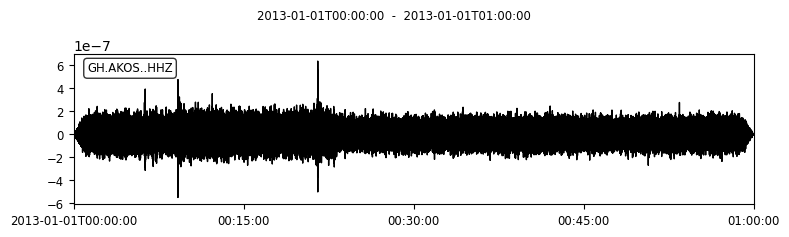

In [11]:
from obspy import read

# Define the path to the mseed file
mseed_file_path = "/content/Mseeds/AKOS_day0_hour0.mseed"

# Read the mseed file
try:
    st_mseed = read(mseed_file_path)

    # Plot the data
    print(f"Plotting data from: {mseed_file_path}")
    st_mseed.plot()

except FileNotFoundError:
    print(f"Error: The file '{mseed_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading or plotting the file: {e}")

Reading 24 mseed files from /content/Mseeds in the following order:
  - AKOS_day0_hour0.mseed
  - AKOS_day0_hour1.mseed
  - AKOS_day0_hour2.mseed
  - AKOS_day0_hour3.mseed
  - AKOS_day0_hour4.mseed
  - AKOS_day0_hour5.mseed
  - AKOS_day0_hour6.mseed
  - AKOS_day0_hour7.mseed
  - AKOS_day0_hour8.mseed
  - AKOS_day0_hour9.mseed
  - AKOS_day0_hour10.mseed
  - AKOS_day0_hour11.mseed
  - AKOS_day0_hour12.mseed
  - AKOS_day0_hour13.mseed
  - AKOS_day0_hour14.mseed
  - AKOS_day0_hour15.mseed
  - AKOS_day0_hour16.mseed
  - AKOS_day0_hour17.mseed
  - AKOS_day0_hour18.mseed
  - AKOS_day0_hour19.mseed
  - AKOS_day0_hour20.mseed
  - AKOS_day0_hour21.mseed
  - AKOS_day0_hour22.mseed
  - AKOS_day0_hour23.mseed

Plotting individual streams in one window...


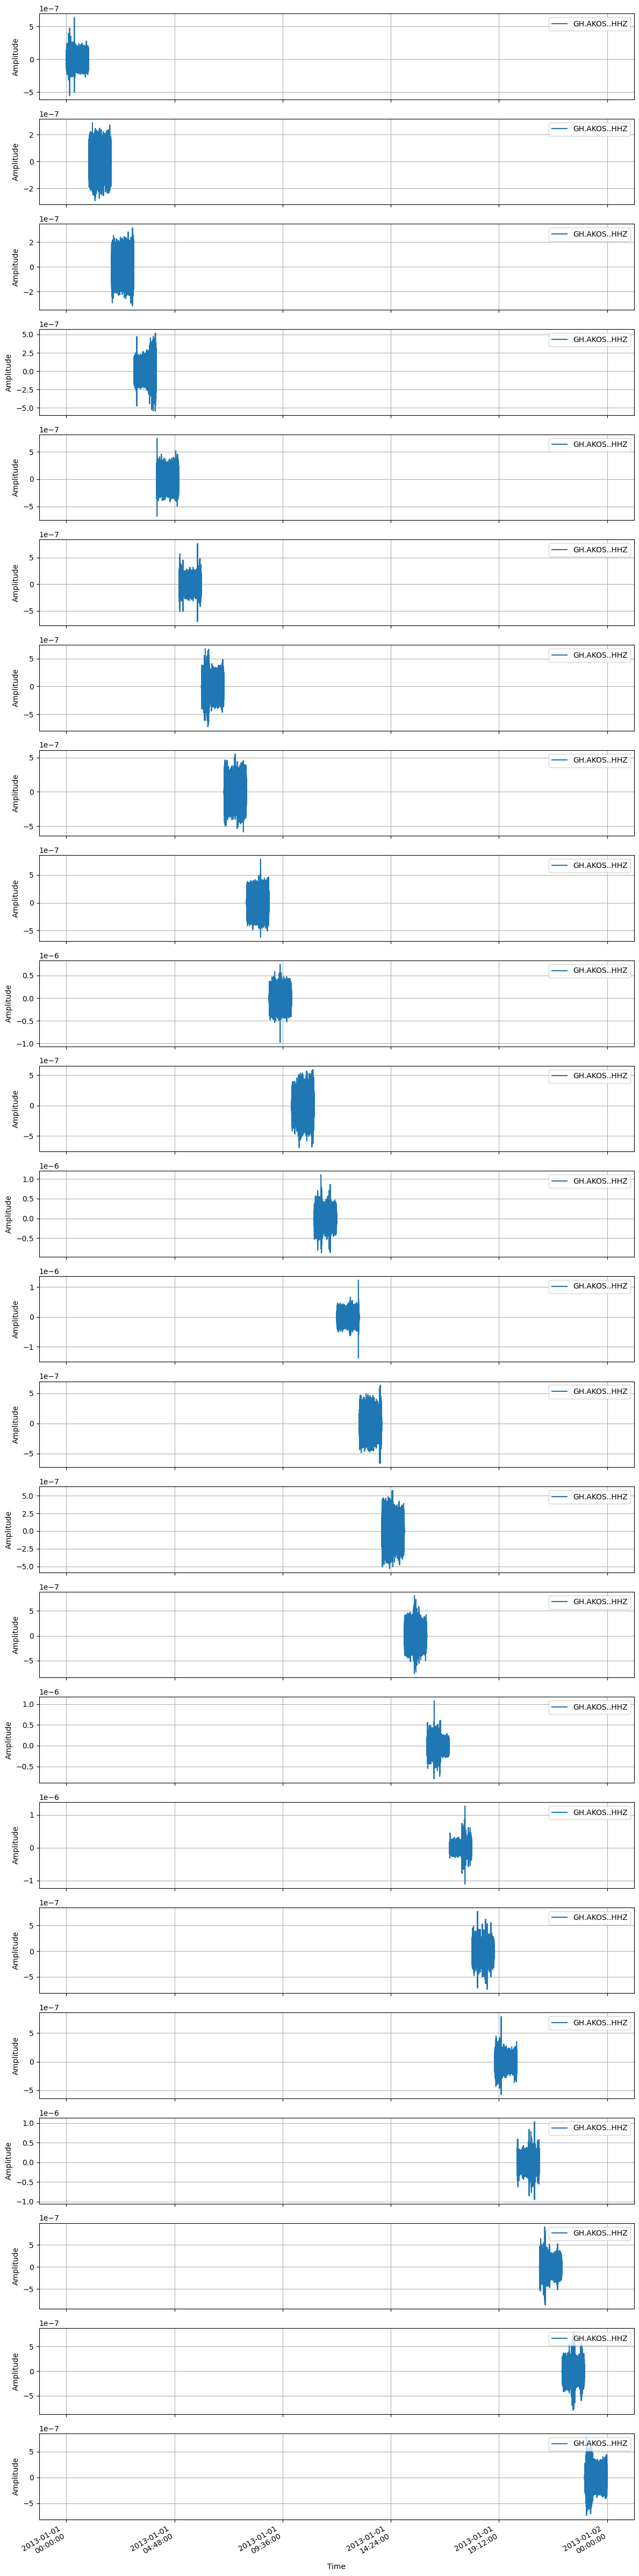

In [12]:
# Import necessary libraries
import glob
from obspy import read
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re # Import the regular expression module for natural sorting

# === STEP 1: DEFINE THE NATURAL SORTING FUNCTION ===
# This function will be used as the key for sorting the file list.
# It splits a filename into text and number parts, allowing for a natural sort.
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('([0-9]+)', s)]

# Define the directory containing the mseed files
mseed_directory = "/content/Mseeds"

# === STEP 2: FIND AND SORT FILES USING THE NEW KEY ===
# Find all .mseed files in the directory
all_files = glob.glob(os.path.join(mseed_directory, "*.mseed"))

# Sort the files using our custom natural_sort_key
mseed_files = sorted(all_files, key=natural_sort_key)

# Check if any files were found
if not mseed_files:
    print(f"No .mseed files found in {mseed_directory}")
else:
    streams_to_plot = []
    print(f"Reading {len(mseed_files)} mseed files from {mseed_directory} in the following order:")
    # Optional: Print the sorted file order to verify
    for f in mseed_files:
        print(f"  - {os.path.basename(f)}")

    for mseed_file in mseed_files:
        try:
            st = read(mseed_file)
            streams_to_plot.append(st)
        except Exception as e:
            print(f"Error reading file {mseed_file}: {e}")

    # === STEP 3: APPLY PLOT (NO CHANGES HERE) ===
    if streams_to_plot:
        print("\nPlotting individual streams in one window...")

        # Create a figure and a set of subplots
        fig, axes = plt.subplots(nrows=len(streams_to_plot), ncols=1, sharex=True, figsize=(12, 2 * len(streams_to_plot)))

        # Handle the case of a single file, where 'axes' is not an array
        if len(streams_to_plot) == 1:
            axes = [axes]

        # Loop through each sorted stream and its corresponding axis
        for st, ax in zip(streams_to_plot, axes):
            # Iterate through each Trace in the Stream
            for tr in st:
                # Use Matplotlib's plot() directly
                ax.plot(tr.times("matplotlib"), tr.data, label=tr.id)

            ax.set_ylabel("Amplitude")
            ax.legend(loc='upper right') # Add a legend to identify traces
            ax.grid(True) # Add a grid for better readability

        # Format the shared x-axis to display dates nicely
        axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M:%S'))
        fig.autofmt_xdate()

        plt.xlabel("Time")
        plt.tight_layout()
        plt.show()

    else:
        print("No data to plot after attempting to read files.")

Reading and splitting 24 files into 1-hour segments...

Plotting 24 one-hour segments in a single window...


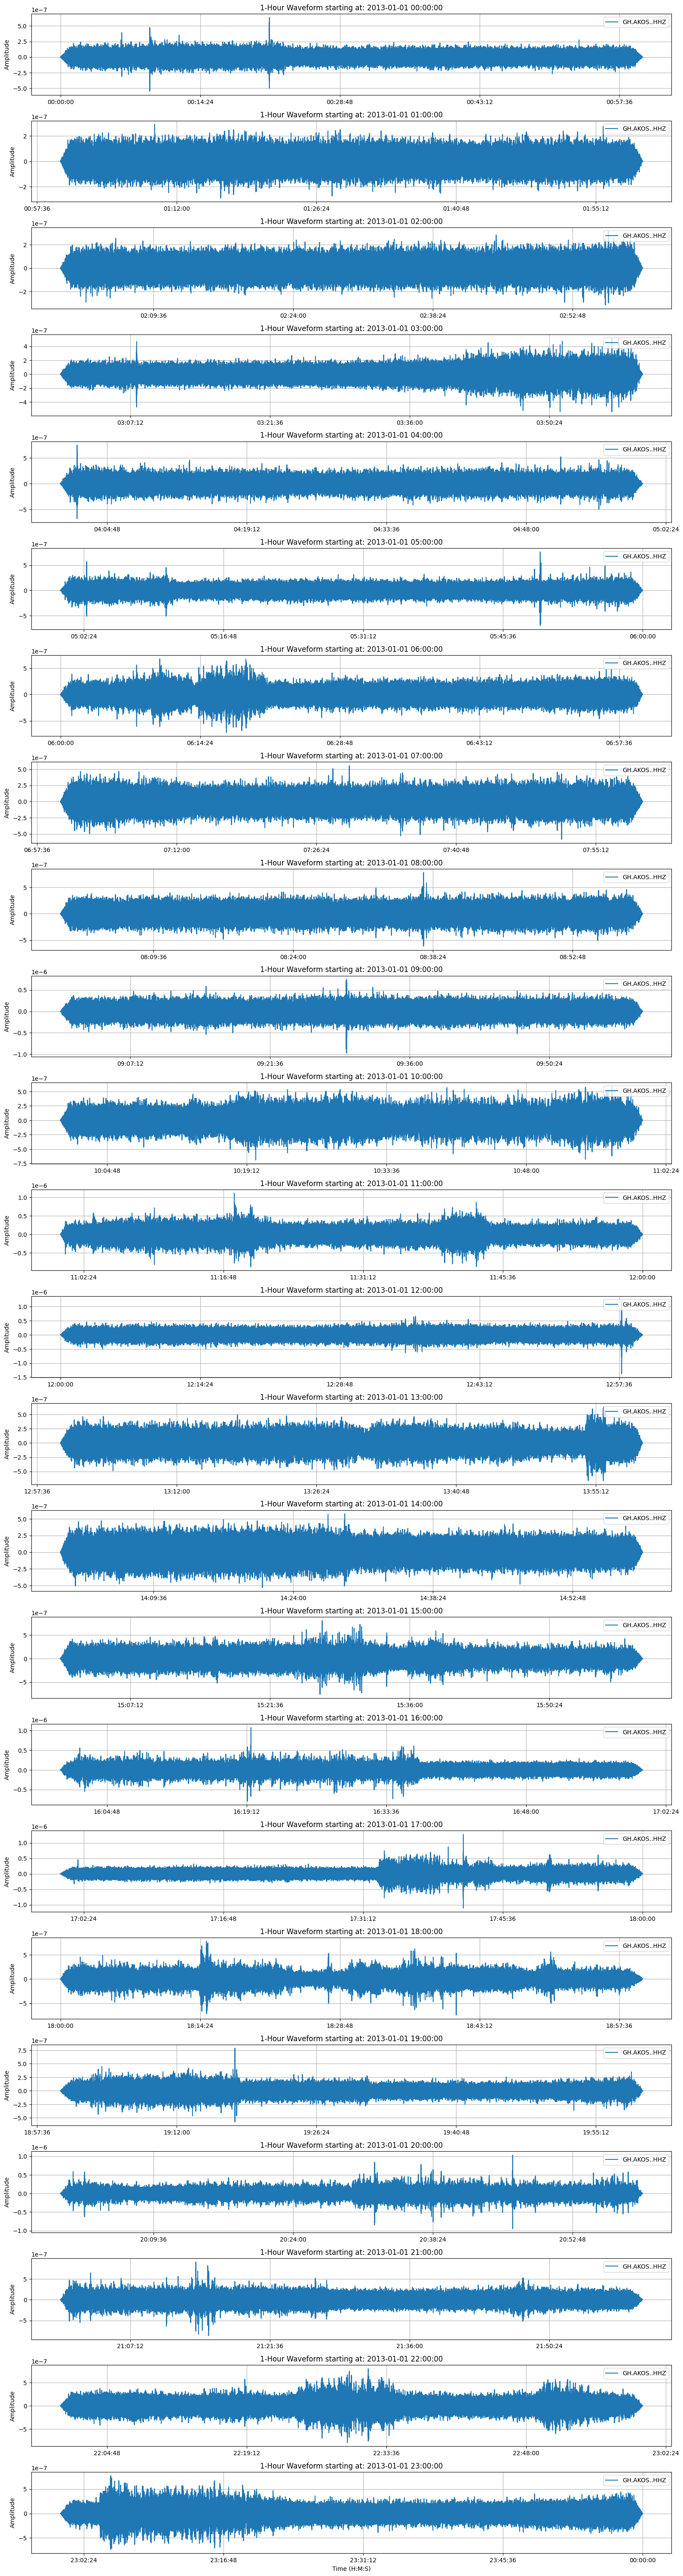

In [13]:
# Import necessary libraries
import glob
from obspy import read, UTCDateTime
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re # For natural sorting

# === 1. NATURAL SORTING FUNCTION ===
def natural_sort_key(s):
    """Sorts strings with numbers in a human-friendly order (e.g., file2 before file10)."""
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('([0-9]+)', s)]

# === 2. SETUP AND FILE READING ===
# Define the directory containing the mseed files
mseed_directory = "/content/Mseeds"

# Find and naturally sort all .mseed files
all_files = glob.glob(os.path.join(mseed_directory, "*.mseed"))
mseed_files = sorted(all_files, key=natural_sort_key)

if not mseed_files:
    print(f"No .mseed files found in {mseed_directory}")
else:
    stream_chunks = []
    print(f"Reading and splitting {len(mseed_files)} files into 1-hour segments...")

    for mseed_file in mseed_files:
        try:
            st = read(mseed_file)
            if not st:
                print(f"  - Skipping empty file: {os.path.basename(mseed_file)}")
                continue

            st.merge(method=1)

            # === 3. SPLIT STREAM INTO 1-HOUR CHUNKS ===
            stream_start = st[0].stats.starttime
            stream_end = st[0].stats.endtime
            current_time = stream_start

            while current_time < stream_end:
                chunk = st.slice(starttime=current_time, endtime=current_time + 3600) # 3600s = 1 hour
                if chunk:
                    stream_chunks.append(chunk)
                current_time += 3600

        except Exception as e:
            print(f"  - Error processing file {os.path.basename(mseed_file)}: {e}")

    # === 4. PLOT ALL THE 1-HOUR CHUNKS ===
    if stream_chunks:
        print(f"\nPlotting {len(stream_chunks)} one-hour segments in a single window...")

        # NOTE: sharex is intentionally False (default) so each plot has its own time window.
        fig, axes = plt.subplots(
            nrows=len(stream_chunks),
            ncols=1,
            figsize=(16, 2.5 * len(stream_chunks))
        )

        if len(stream_chunks) == 1:
            axes = [axes]

        for chunk, ax in zip(stream_chunks, axes):
            start_time_str = chunk[0].stats.starttime.strftime('%Y-%m-%d %H:%M:%S')

            # Plot the 1-hour waveform
            for tr in chunk:
                ax.plot(tr.times("matplotlib"), tr.data, label=tr.id)

            ax.set_title(f"1-Hour Waveform starting at: {start_time_str}")
            ax.set_ylabel("Amplitude")
            ax.legend(loc='upper right')
            ax.grid(True)

            # === FIX: APPLY TIME FORMATTER TO EVERY SUBPLOT ===
            # This line is now INSIDE the loop.
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

        # Set the x-axis label only for the bottom plot
        plt.xlabel("Time (H:M:S)")
        fig.tight_layout(pad=1.0)
        plt.show()
    else:
        print("\nNo valid data segments found to plot.")

##fetching

In [14]:
import numpy as np

# Define the path to the .npy file
npy_file_path = "/content/AutoCorr_Outputs/AKOS_day0_hour0.npy"

# Read the .npy file
try:
    data = np.load(npy_file_path)

    # Display the data (e.g., its shape and a few values)
    print(f"Successfully read data from: {npy_file_path}")
    print(f"Data shape: {data.shape}")
    display(data)

except FileNotFoundError:
    print(f"Error: The file '{npy_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

Successfully read data from: /content/AutoCorr_Outputs/AKOS_day0_hour0.npy
Data shape: (1, 360001)


array([[-1.69594696e-11,  1.22729902e-11, -3.98645024e-11, ...,
        -2.27685987e-11,  3.40123047e-11, -3.04015671e-11]])

In [15]:
import os
import numpy as np
import glob
import re

# 1. Define paths
source_directory = "/content/AutoCorr_Outputs"
output_directory = "/content/Final"
output_filename = "combined_data.npy"
output_path = os.path.join(output_directory, output_filename)
slice_length = 60000 # The first 60000 values to keep

# 2. List and sort files
# Using the natural sorting key defined previously (assuming it's available in the environment)
# If not, redefine it here:
def natural_sort_key(s):
    """Sorts strings with numbers in a human-friendly order (e.g., file2 before file10)."""
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('([0-9]+)', s)]

all_npy_files = glob.glob(os.path.join(source_directory, "*.npy"))
sorted_npy_files = sorted(all_npy_files, key=natural_sort_key)

if not sorted_npy_files:
    print(f"No .npy files found in {source_directory}")
else:
    print(f"Found {len(sorted_npy_files)} .npy files. Processing...")
    processed_data_list = []

    # 3. Process and collect data
    for file_path in sorted_npy_files:
        try:
            arr = np.load(file_path)
            # Ensure the array has at least slice_length elements
            if arr.size >= slice_length:
                # Take the first slice_length elements. Assuming the data is 1D or can be flattened.
                # If the arrays are consistently 2D with shape (1, N), arr[0, :slice_length] is appropriate.
                # Based on the output of Tvw4BGRAvTy_, the shape is (1, 360001).
                sliced_arr = arr[0, :slice_length]
                processed_data_list.append(sliced_arr)
                print(f"Processed {os.path.basename(file_path)}. Sliced shape: {sliced_arr.shape}")
            else:
                print(f"Skipping {os.path.basename(file_path)}: array size ({arr.size}) is less than required ({slice_length}).")

        except Exception as e:
            print(f"Error processing file {os.path.basename(file_path)}: {e}")

    # 4. Combine data
    if processed_data_list:
        # Stack the sliced arrays vertically to create a single 2D array
        combined_data = np.vstack(processed_data_list)
        print(f"\nCombined data shape: {combined_data.shape}")

        # 5. Create output directory
        os.makedirs(output_directory, exist_ok=True)
        print(f"Ensured output directory '{output_directory}' exists.")

        # 6. Save combined data
        np.save(output_path, combined_data)
        print(f"Successfully saved combined data to '{output_path}'")

        # 7. Finish task - Implicitly done by the print statement above
    else:
        print("\nNo data was processed to combine.")

Found 48 .npy files. Processing...
Processed AKOS_day0_hour0.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour1.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour2.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour3.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour4.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour5.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour6.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour7.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour8.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour9.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour10.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour11.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour12.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour13.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour14.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour15.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour16.npy. Sliced shape: (60000,)
Processed AKOS_day0_hour17.npy. Sliced s

##Model

In [16]:
# Helper function for custom accuracy
def regression_accuracy(y_true, y_pred):
    """
    Calculates a custom accuracy metric for regression tasks.
    A prediction is considered "accurate" if its absolute error is
    less than a certain threshold (e.g., 5% of the true value's range).
    """
    # Define a tolerance. Let's say 5% of the typical signal range.
    # IMPORTANT: You should adjust this threshold based on your data!
    # If your normalized data is between 0 and 1, a 0.05 threshold is 5%.
    TOLERANCE = 0.05

    # Calculate the absolute difference between the true and predicted values
    error = tf.abs(y_true - y_pred)

    # Check where the error is less than our tolerance
    is_accurate = tf.less(error, TOLERANCE)

    # Cast boolean (True/False) to float (1.0/0.0) and find the mean
    # This gives the percentage of "accurate" predictions
    return tf.reduce_mean(tf.cast(is_accurate, tf.float32))

In [17]:
TOLERANCE = 0.05 # Global tolerance for accuracy calculation

def regression_accuracy(y_true, y_pred):
    """
    A prediction is "accurate" if its absolute error is less than TOLERANCE.
    """
    error = tf.abs(y_true - y_pred)
    is_accurate = tf.less(error, TOLERANCE)
    return tf.reduce_mean(tf.cast(is_accurate, tf.float32))

In [18]:
class AutocorrelationLayer(tf.keras.layers.Layer):
    """Computes the full autocorrelation of the input signal."""
    def __init__(self, **kwargs):
        super(AutocorrelationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        if len(inputs.shape) == 3 and inputs.shape[-1] == 1:
            inputs = tf.squeeze(inputs, axis=-1)
        f = tf.signal.rfft(inputs)
        power_spectral_density = f * tf.math.conj(f)
        autocorr = tf.signal.irfft(power_spectral_density)
        return autocorr

In [19]:
def build_model(input_shape=(60000,), final_output_points=1000):
    """Builds the model: Input -> Full Autocorrelation -> Dense -> Output"""
    inputs = tf.keras.layers.Input(shape=input_shape)
    autocorr_output = AutocorrelationLayer(name='autocorrelation_layer')(inputs)
    dense_output = tf.keras.layers.Dense(units=final_output_points, activation='relu')(autocorr_output)
    final_output = tf.keras.layers.Reshape((1, final_output_points))(dense_output)
    model = tf.keras.Model(inputs=inputs, outputs=final_output)
    return model


In [20]:
def create_target_data(input_signals, num_points):
    """Calculates the autocorrelation for each signal and slices the first `num_points`."""
    signals_tensor = tf.convert_to_tensor(input_signals, dtype=tf.float32)
    f = tf.signal.rfft(signals_tensor)
    power_spectral_density = f * tf.math.conj(f)
    autocorr = tf.signal.irfft(power_spectral_density)
    target = autocorr[:, :num_points].numpy()
    return target.reshape(target.shape[0], 1, target.shape[1])

Input data (X) loaded. Shape: (48, 60000)
Target data (y) created. Shape: (48, 1, 1000)

Model Architecture Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ autocorrelation_layer           │ (None, 60000)          │             0 │
│ (AutocorrelationLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │    60,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1000)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,001,000 (228.89 MB)

 Trainable params: 60,001,000 (228.89 MB)

 Non-trainable params: 0 (0.00 B)


Starting model training on the entire dataset...
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 872ms/step - loss: 1.5809e-21 - mae: 1.2529e-11 - regression_accuracy: 1.0000
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 1.3054e-21 - mae: 1.1144e-11 - regression_accuracy: 1.0000
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 867ms/step - loss: 5.2772e-22 - mae: 8.3615e-12 - regression_accuracy: 1.0000
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 6.3046e-22 - mae: 9.1598e-12 - regression_accuracy: 1.0000
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 1.2514e-21 - mae: 1.1656e-11 - regression_accuracy: 1.0000  
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 932ms/step - loss: 6.7421e-22 - mae: 9.4774e-12 - regression_accuracy: 1.0000
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 1.8790e-21 - mae: 1.4134e-11 - regression_accuracy: 1.0000
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 869ms/step - loss: 1.8255e-21 - mae: 1.3108e-11 - regression_accuracy: 1.0000
Epoch 9/10
6/6 ━━━━━━

Training finished.

 Final model saved successfully to: /content/Final/final_model.h5

Extracting output from the Autocorrelation layer...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
 Autocorrelation result for one sample saved successfully to: /content/Final/autocorrelation_result.npy
Shape of the saved autocorrelation result: (1, 60000)

Chart of training history saved to 'training_history.png'.


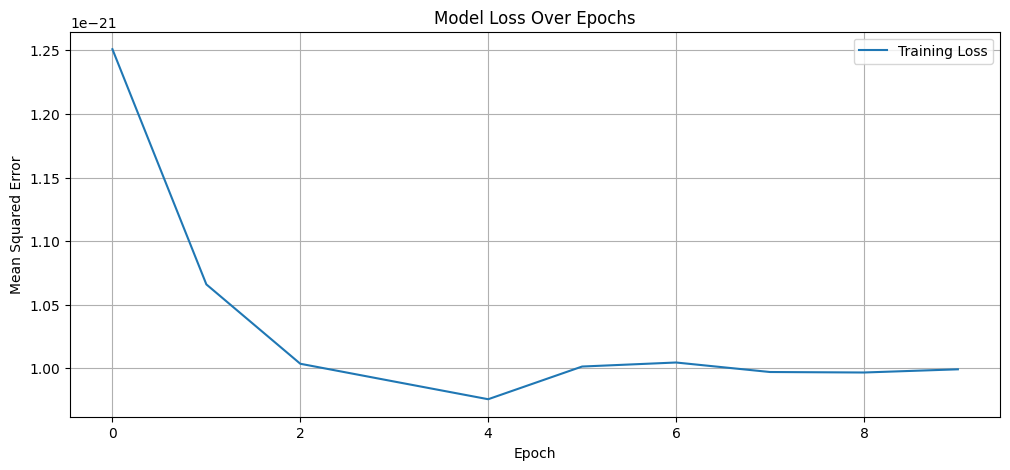

In [21]:
file_path = '/content/Final/combined_data.npy'
output_dir = '/content/Final'
FINAL_OUTPUT_POINTS = 1000

try:
    # --- Setup and Data Preparation ---
    os.makedirs(output_dir, exist_ok=True)

    if not os.path.exists(file_path):
        print(f"File not found. Creating a dummy data file...")
        dummy_data = np.random.randn(48, 60000)
        np.save(file_path, dummy_data)
        print("Dummy file created.")

    X = np.load(file_path)
    print(f"Input data (X) loaded. Shape: {X.shape}")

    y = create_target_data(X, num_points=FINAL_OUTPUT_POINTS)
    print(f"Target data (y) created. Shape: {y.shape}")

    # --- Model Building and Compilation ---
    model = build_model(
        input_shape=(60000,),
        final_output_points=FINAL_OUTPUT_POINTS
    )

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae', regression_accuracy]
    )

    print("\nModel Architecture Summary:")
    model.summary()

    # --- Model Training on the Entire Dataset ---
    print("\nStarting model training on the entire dataset...")
    history = model.fit(
        X, y, # <-- Pass the entire dataset (X, y)
        epochs=10,
        batch_size=8,
        shuffle=True # Good practice to shuffle data during training
        # No validation_data argument is needed
    )
    print("Training finished.")

    # --- Save the Final Trained Model in H5 Format ---
    model_save_path = os.path.join(output_dir, 'final_model.h5')
    model.save(model_save_path)
    print(f"\n Final model saved successfully to: {model_save_path}")

    # --- Extract and Save Autocorrelation Layer Output ---
    print("\nExtracting output from the Autocorrelation layer...")
    autocorr_extractor_model = tf.keras.Model(
        inputs=model.input,
        outputs=model.get_layer('autocorrelation_layer').output
    )

    # Use the first sample from the full dataset to get the result
    sample_input = X[0:1]
    autocorr_result = autocorr_extractor_model.predict(sample_input)

    autocorr_save_path = os.path.join(output_dir, 'autocorrelation_result.npy')
    np.save(autocorr_save_path, autocorr_result)
    print(f" Autocorrelation result for one sample saved successfully to: {autocorr_save_path}")
    print(f"Shape of the saved autocorrelation result: {autocorr_result.shape}")

    # --- Visualization of Training Loss ---
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    print("\nChart of training history saved to 'training_history.png'.")

except Exception as e:
    print(f"\nAn error occurred: {e}")

Successfully loaded autocorrelation data from: /content/Final/autocorrelation_result.npy
Data shape: (1, 60000)


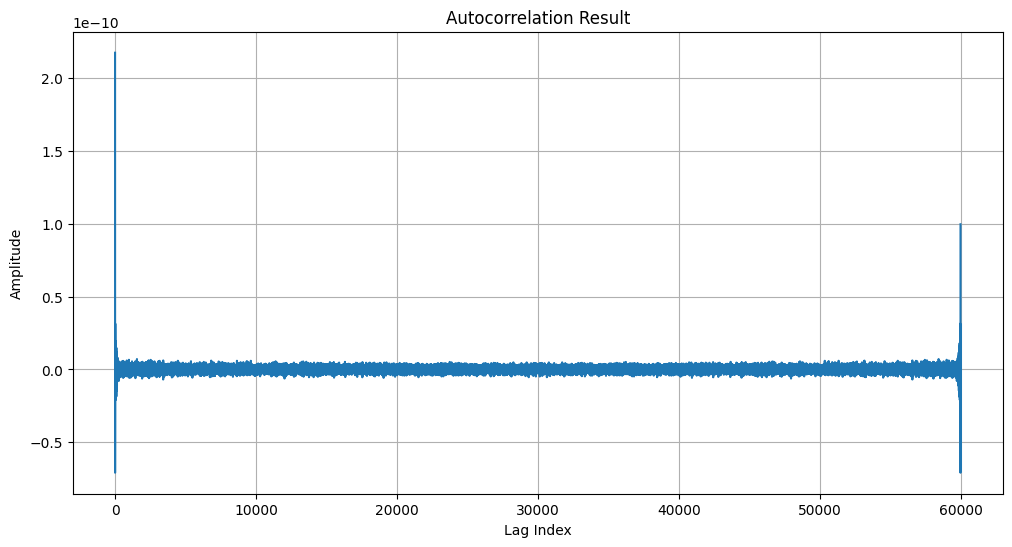

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the path to the autocorrelation result file
autocorr_file_path = "/content/Final/autocorrelation_result.npy"

# Load the autocorrelation result
try:
    autocorr_data = np.load(autocorr_file_path)

    print(f"Successfully loaded autocorrelation data from: {autocorr_file_path}")
    print(f"Data shape: {autocorr_data.shape}")

    # Assuming the data is a single sample (shape (1, N) or (N,))
    # Flatten if it's (1, N) to get a 1D array for plotting
    if autocorr_data.shape[0] == 1:
        autocorr_data_1d = autocorr_data.flatten()
    else:
        autocorr_data_1d = autocorr_data # Assume it's already 1D or can be plotted as is

    # Plot the autocorrelation result
    plt.figure(figsize=(12, 6))
    plt.plot(autocorr_data_1d)
    plt.title("Autocorrelation Result")
    plt.xlabel("Lag Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{autocorr_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while loading or plotting the file: {e}")